In [1]:
import sys
sys.path.append('../')  # necessary for relative import

import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt

from tqdm import tqdm
from mygwr.gwr import GWR as myGWR
from mgwr.gwr import GWR as pysalGWR
from mygwr.sel_bw import Sel_BW
from libpysal.weights import Queen
from multiprocessing.pool import ThreadPool
from spopt.region import RegionKMeansHeuristic

N_TX_TRACTS = 5204

# Prep data

In [2]:
# Load tract level data
TXtracts = gpd.read_file('../../data/tx_tracts_raw.json')
TXtracts['county'] = TXtracts['county'].astype(int)
TXtracts = TXtracts.set_crs(epsg=3395, allow_override=True)
Wt = Queen.from_dataframe(TXtracts)

In [3]:
# Dani's spatially autocorrelated generator function
def draw_map(N, lamb, W):
    """
    N    = number of areal units
    lamb = parameter for how correlated it should be
    W    = spatial weights matrix
    """

    W.transform = 'R'
    e = np.random.random((N, 1))
    u = np.linalg.inv(np.eye(N) - lamb * W.full()[0])
    u = np.dot(u, e)
    u = (u - u.mean()) / np.std(u)
    return u

In [4]:
# Regionalize to 50 regions
N = 50
true_reg = RegionKMeansHeuristic(TXtracts[['B19019_001E', 'B23006_001E']].values, N, Wt)
true_reg.solve()
TXtracts['true_labels'] = true_reg.labels_
true_data = TXtracts.dissolve(by='true_labels', aggfunc='mean')
true_wgts = Queen.from_dataframe(true_data)

# Generate true level covariates
lamb1, lamb2 = 0.95, 0.9
X1_true = draw_map(N, lamb1, true_wgts)
X2_true = draw_map(N, lamb2, true_wgts)
X_true = np.hstack((X1_true, X2_true))
true_data['X1_true'] = X1_true
true_data['X2_true'] = X2_true

# Fix parameters and generate meso level response
alpha_true = 1
beta_true = np.array([3, -2]).T
epsilon = np.random.normal(loc=0, scale=1, size=N)
Y_true = alpha_true + X_true @ beta_true + epsilon
true_data['Y_true'] = Y_true

In [5]:
# Join data to tracts
tract_data = TXtracts.set_index('true_labels').join(true_data, how='left', rsuffix='_true')

# Downsample
gamma = 1
noiselvl = 0.25
tract_data['X1_t'] = np.random.normal(loc=gamma*tract_data['X1_true'], scale=noiselvl)
tract_data['X2_t'] = np.random.normal(loc=gamma*tract_data['X2_true'], scale=noiselvl)
tract_data['Y_t']  = np.random.normal(loc=gamma*tract_data['Y_true'],  scale=noiselvl)

2021-11-18 11:24:33,292 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-11-18 11:24:33,294 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


<AxesSubplot:>

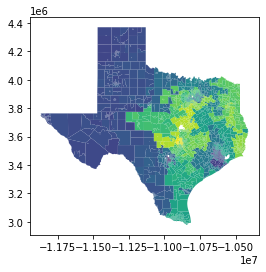

In [6]:
tract_data.plot('Y_t')

In [19]:
coords = np.hstack((tract_data.centroid.values.x.reshape(-1, 1), tract_data.centroid.values.y.reshape(-1, 1)))
y = tract_data['Y_t'].values.reshape(-1, 1)
X = tract_data[['X1_t', 'X2_t']].values

In [11]:
model = pysalGWR(coords, y, X, 50).fit()

In [12]:
mymodel = myGWR(coords, y, X, 50).fit()

<AxesSubplot:>

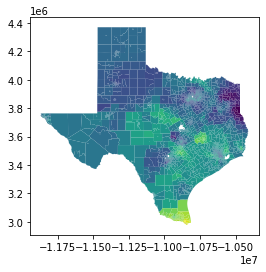

In [18]:
tract_data['myparams'] = mymodel.params[:, 1].flatten()
tract_data.plot('myparams')

In [13]:
print(model.aicc, mymodel.loss())

11486.955430421564 13785.54717398327


In [21]:
pool = ThreadPool(8)
grid_selector = Sel_BW(coords, y, X, optimizer='grid')
grid_results = grid_selector.select(bw_min=2, bw_max=200, full=True, pool=pool)

/mnt/c/Users/tyler/OneDrive/Documents/year1/GIS563/project2/code/notebooks/../mygwr/gwr.py:92: RuntimeWarning: invalid value encountered in log
  return self.n*np.log(sigma2) + self.n*np.log(2*np.pi) + self.n*(self.n + k)/(self.n - k - 2)


LinAlgError: Singular matrix

In [ ]:
plt.plot(grid_results['losses'])